In [1]:
%matplotlib inline

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
data = pd.read_csv("input/train_indessa.csv")

## Preprocessing

In [3]:
data = data.fillna("0")

In [4]:
data['last_week_pay'] = data['last_week_pay'].str.extract('(\d+)', expand=False)
data = data.fillna("0")
data['last_week_pay'] = data['last_week_pay'].astype(int)

In [5]:
data['term'] = data['term'].str.extract('(\d+)', expand=False).astype(int)
data = data.fillna("0")
data['term'] = data['term'].astype(int)

In [6]:
# Extract a new feature from term and last week pay

data.insert(0, 'payment_completion', (data['last_week_pay']/(data['term']/12*52+1))*100)
data['payment_completion'] = data['payment_completion'].astype(int)

In [7]:
# Extract a new feature from funded_amnt_inv / loan_amnt

data.insert(0, 'funded_ratio', (data['funded_amnt_inv']/data['loan_amnt'])*100)
data['funded_ratio'] = data['funded_ratio'].astype(int)

In [8]:
# Drop irrelevant features and text features
drop_cols = ['member_id', 'batch_enrolled', 'desc', 'title', 'emp_title']
data.drop(drop_cols, 1, inplace=True)

In [9]:
# Encode Label for Classifier
from sklearn.preprocessing import LabelEncoder

cat_cols = ['grade', 'sub_grade', 'emp_length', 'home_ownership', 'verification_status', 
            'pymnt_plan', 'purpose', 'initial_list_status', 'application_type', 
            'verification_status_joint', 'zip_code', 'addr_state']
le = {}

for col in cat_cols:
    le[col] = LabelEncoder()
    data[col] = le[col].fit_transform(data[col])
    le[col].classes_ = np.append(le[col].classes_, 'other')
    
    print('Encoded: ', col)

Encoded:  grade
Encoded:  sub_grade
Encoded:  emp_length
Encoded:  home_ownership
Encoded:  verification_status
Encoded:  pymnt_plan
Encoded:  purpose
Encoded:  initial_list_status
Encoded:  application_type
Encoded:  verification_status_joint
Encoded:  zip_code
Encoded:  addr_state


## Split Training Set

In [10]:
split = int(len(data)*0.75)

# four most important features, performance score = 0.8685
major = ['tot_cur_bal', 'last_week_pay', 'total_rev_hi_lim', 'int_rate']

# not so important features, performance score = 0.7634
minor = ['tot_cur_bal','zip_code', 'addr_state', 'revol_util', 'revol_bal', 'sub_grade', 'annual_inc', 'total_rec_int']

data = data.dropna()
X_train = data[data['loan_status'] >= 0].iloc[:split,:-1]
Y_train = data[data['loan_status'] >= 0].iloc[:split,-1:]
X_test = data[data['loan_status'] >= 0].iloc[split:,:-1]
Y_test = data[data['loan_status'] >= 0].iloc[split:,-1:]

## Ensembled Model #1: Random Forest Classifier

In [11]:
from sklearn.ensemble import RandomForestClassifier

In [12]:
rf = RandomForestClassifier(n_estimators=100, verbose=5, n_jobs=-1)
rf.fit(X_train, Y_train)

/home/carnd/anaconda3/envs/dl/lib/python3.5/site-packages/ipykernel/__main__.py:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  from ipykernel import kernelapp as app


building tree 1 of 100building tree 2 of 100building tree 3 of 100building tree 5 of 100building tree 6 of 100building tree 7 of 100building tree 9 of 100building tree 11 of 100building tree 12 of 100building tree 13 of 100building tree 14 of 100building tree 4 of 100building tree 15 of 100building tree 8 of 100building tree 18 of 100building tree 19 of 100building tree 21 of 100building tree 22 of 100building tree 10 of 100building tree 17 of 100building tree 24 of 100building tree 25 of 100building tree 20 of 100building tree 27 of 100building tree 28 of 100building tree 23 of 100building tree 29 of 100building tree 30 of 100building tree 16 of 100building tree 26 of 100building tree 32 of 100building tree 33 of 100building tree 34 of 100building tree 31 of 100building tree 35 of 100building tree 36 of 100



































building tree 37 of 100
building tree 38 of 100
building tree 39 of 100
building tree 40 of 100
building tree 41 of 100
building tree 42 of 100
b

[Parallel(n_jobs=-1)]: Done  50 out of 100 | elapsed:    6.7s remaining:    6.7s


building tree 87 of 100
building tree 88 of 100
building tree 89 of 100
building tree 90 of 100
building tree 91 of 100
building tree 92 of 100
building tree 93 of 100
building tree 94 of 100
building tree 95 of 100
building tree 96 of 100
building tree 97 of 100
building tree 98 of 100
building tree 99 of 100
building tree 100 of 100


[Parallel(n_jobs=-1)]: Done  71 out of 100 | elapsed:    8.5s remaining:    3.5s
[Parallel(n_jobs=-1)]: Done  92 out of 100 | elapsed:    9.6s remaining:    0.8s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   10.0s finished


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=100, n_jobs=-1, oob_score=False,
            random_state=None, verbose=5, warm_start=False)

In [13]:
rf.score(X_test, Y_test)

[Parallel(n_jobs=36)]: Done  50 out of 100 | elapsed:    0.3s remaining:    0.3s
[Parallel(n_jobs=36)]: Done  71 out of 100 | elapsed:    0.4s remaining:    0.2s
[Parallel(n_jobs=36)]: Done  92 out of 100 | elapsed:    0.4s remaining:    0.0s
[Parallel(n_jobs=36)]: Done 100 out of 100 | elapsed:    0.5s finished


0.85933872748991413

## Ensembled Model #2: KNeighbors Classifier

In [14]:
from sklearn.neighbors import KNeighborsClassifier

In [ ]:
from sklearn.model_selection import validation_curve

knc_train_scores, knc_valid_scores = validation_curve(KNeighborsClassifier(), X_train, Y_train.values.reshape(-1), 
                                             'n_neighbors', np.arange(5,50,5), n_jobs=-1, verbose=2)

In [ ]:
knc_train_scores_mean = np.mean(knc_train_scores, axis=1)
knc_train_scores_std = np.std(knc_train_scores, axis=1)
knc_valid_scores_mean = np.mean(knc_valid_scores, axis=1)
knc_valid_scores_std = np.std(knc_valid_scores, axis=1)
knc_param_range = np.arange(5,50,5)

In [ ]:
plt.title("Validation Curve with KNeighbors")
plt.xlabel("n_neighbors")
plt.ylabel("Score")
lw=2
plt.plot(knc_param_range, knc_train_scores_mean, label="Training score",
             color="darkorange", lw=lw)
plt.plot(knc_param_range, knc_valid_scores_mean, label="Cross-validation score",
             color="navy", lw=lw)
plt.legend(loc="best")
plt.show()
plt.show()

In [15]:
knc = KNeighborsClassifier(n_neighbors=20, n_jobs=-1)
knc.fit(X_train, Y_train)

/home/carnd/anaconda3/envs/dl/lib/python3.5/site-packages/ipykernel/__main__.py:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  from ipykernel import kernelapp as app


KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=-1, n_neighbors=20, p=2,
           weights='uniform')

In [16]:
knc.score(X_test, Y_test)

0.80946156099979716

## Ensembled Model #3: SGD Classifier

In [17]:
from sklearn.linear_model import SGDClassifier

In [18]:
sgd = SGDClassifier(loss='modified_huber', verbose=2, n_jobs=-1, n_iter=1000)
sgd.fit(X_train, Y_train)

/home/carnd/anaconda3/envs/dl/lib/python3.5/site-packages/sklearn/utils/validation.py:526: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


-- Epoch 1
Norm: 413570.88, NNZs: 41, Bias: 1881.693677, T: 399321, Avg. loss: 19927667685.546288
Total training time: 0.08 seconds.
-- Epoch 2
Norm: 323846.31, NNZs: 41, Bias: 2015.243554, T: 798642, Avg. loss: 11171258276.007132
Total training time: 0.17 seconds.
-- Epoch 3
Norm: 282477.20, NNZs: 41, Bias: 2090.461013, T: 1197963, Avg. loss: 7921208927.643699
Total training time: 0.26 seconds.
-- Epoch 4
Norm: 254291.27, NNZs: 41, Bias: 2133.530384, T: 1597284, Avg. loss: 6199356689.409877
Total training time: 0.34 seconds.
-- Epoch 5
Norm: 235023.27, NNZs: 41, Bias: 2162.040643, T: 1996605, Avg. loss: 5113431449.436664
Total training time: 0.43 seconds.
-- Epoch 6
Norm: 219378.13, NNZs: 41, Bias: 2179.214138, T: 2395926, Avg. loss: 4366939947.848230
Total training time: 0.51 seconds.
-- Epoch 7
Norm: 207938.77, NNZs: 41, Bias: 2197.842419, T: 2795247, Avg. loss: 3820780398.853961
Total training time: 0.60 seconds.
-- Epoch 8
Norm: 197808.71, NNZs: 41, Bias: 2208.078782, T: 3194568, 

SGDClassifier(alpha=0.0001, average=False, class_weight=None, epsilon=0.1,
       eta0=0.0, fit_intercept=True, l1_ratio=0.15,
       learning_rate='optimal', loss='modified_huber', n_iter=1000,
       n_jobs=-1, penalty='l2', power_t=0.5, random_state=None,
       shuffle=True, verbose=2, warm_start=False)

In [19]:
sgd.score(X_test, Y_test)

0.72123930371806144

## Ensembled Model #4: AdaBoostClassifier

In [30]:
from sklearn.ensemble import AdaBoostClassifier

In [31]:
abc = AdaBoostClassifier()
abc.fit(X_train, Y_train)

/home/carnd/anaconda3/envs/dl/lib/python3.5/site-packages/sklearn/utils/validation.py:526: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None,
          learning_rate=1.0, n_estimators=50, random_state=None)

In [32]:
abc.score(X_test, Y_test)

0.83326947493369996

## Ensembled Model #5: Bagging Classifier

In [33]:
from sklearn.ensemble import BaggingClassifier

In [42]:
from sklearn.model_selection import validation_curve

bc_train_scores, bc_valid_scores = validation_curve(BaggingClassifier(n_jobs=-1), X_train, Y_train.values.reshape(-1), 
                                             'n_estimators', np.arange(50,550,50), n_jobs=-1, verbose=2)

[CV] n_estimators=50 .................................................
[CV] n_estimators=100 ................................................
[CV] n_estimators=150 ................................................


/home/carnd/anaconda3/envs/dl/lib/python3.5/site-packages/sklearn/externals/joblib/parallel.py:540: UserWarning: Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1
  **self._backend_args)


[CV] n_estimators=200 ................................................


/home/carnd/anaconda3/envs/dl/lib/python3.5/site-packages/sklearn/externals/joblib/parallel.py:540: UserWarning: Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1
  **self._backend_args)
/home/carnd/anaconda3/envs/dl/lib/python3.5/site-packages/sklearn/externals/joblib/parallel.py:540: UserWarning: Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1
  **self._backend_args)


[CV] n_estimators=250 ................................................
[CV] n_estimators=300 ................................................


/home/carnd/anaconda3/envs/dl/lib/python3.5/site-packages/sklearn/externals/joblib/parallel.py:540: UserWarning: Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1
  **self._backend_args)


[CV] n_estimators=350 ................................................


/home/carnd/anaconda3/envs/dl/lib/python3.5/site-packages/sklearn/externals/joblib/parallel.py:540: UserWarning: Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1
  **self._backend_args)


[CV] n_estimators=400 ................................................


/home/carnd/anaconda3/envs/dl/lib/python3.5/site-packages/sklearn/externals/joblib/parallel.py:540: UserWarning: Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1
  **self._backend_args)


[CV] n_estimators=450 ................................................


/home/carnd/anaconda3/envs/dl/lib/python3.5/site-packages/sklearn/externals/joblib/parallel.py:540: UserWarning: Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1
  **self._backend_args)


[CV] n_estimators=500 ................................................


/home/carnd/anaconda3/envs/dl/lib/python3.5/site-packages/sklearn/externals/joblib/parallel.py:540: UserWarning: Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1
  **self._backend_args)


[CV] n_estimators=50 .................................................


/home/carnd/anaconda3/envs/dl/lib/python3.5/site-packages/sklearn/externals/joblib/parallel.py:540: UserWarning: Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1
  **self._backend_args)


[CV] n_estimators=100 ................................................


/home/carnd/anaconda3/envs/dl/lib/python3.5/site-packages/sklearn/externals/joblib/parallel.py:540: UserWarning: Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1
  **self._backend_args)


[CV] n_estimators=150 ................................................


/home/carnd/anaconda3/envs/dl/lib/python3.5/site-packages/sklearn/externals/joblib/parallel.py:540: UserWarning: Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1
  **self._backend_args)


[CV] n_estimators=200 ................................................


/home/carnd/anaconda3/envs/dl/lib/python3.5/site-packages/sklearn/externals/joblib/parallel.py:540: UserWarning: Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1
  **self._backend_args)


[CV] n_estimators=250 ................................................


/home/carnd/anaconda3/envs/dl/lib/python3.5/site-packages/sklearn/externals/joblib/parallel.py:540: UserWarning: Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1
  **self._backend_args)


[CV] n_estimators=300 ................................................


/home/carnd/anaconda3/envs/dl/lib/python3.5/site-packages/sklearn/externals/joblib/parallel.py:540: UserWarning: Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1
  **self._backend_args)


[CV] n_estimators=350 ................................................


/home/carnd/anaconda3/envs/dl/lib/python3.5/site-packages/sklearn/externals/joblib/parallel.py:540: UserWarning: Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1
  **self._backend_args)
/home/carnd/anaconda3/envs/dl/lib/python3.5/site-packages/sklearn/externals/joblib/parallel.py:540: UserWarning: Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1
  **self._backend_args)


[CV] n_estimators=400 ................................................


/home/carnd/anaconda3/envs/dl/lib/python3.5/site-packages/sklearn/externals/joblib/parallel.py:540: UserWarning: Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1
  **self._backend_args)


[CV] n_estimators=450 ................................................
[CV] n_estimators=500 ................................................
[CV] n_estimators=50 .................................................


/home/carnd/anaconda3/envs/dl/lib/python3.5/site-packages/sklearn/externals/joblib/parallel.py:540: UserWarning: Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1
  **self._backend_args)
/home/carnd/anaconda3/envs/dl/lib/python3.5/site-packages/sklearn/externals/joblib/parallel.py:540: UserWarning: Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1
  **self._backend_args)


[CV] n_estimators=100 ................................................


/home/carnd/anaconda3/envs/dl/lib/python3.5/site-packages/sklearn/externals/joblib/parallel.py:540: UserWarning: Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1
  **self._backend_args)


[CV] n_estimators=150 ................................................


/home/carnd/anaconda3/envs/dl/lib/python3.5/site-packages/sklearn/externals/joblib/parallel.py:540: UserWarning: Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1
  **self._backend_args)


[CV] n_estimators=200 ................................................
[CV] n_estimators=250 ................................................


/home/carnd/anaconda3/envs/dl/lib/python3.5/site-packages/sklearn/externals/joblib/parallel.py:540: UserWarning: Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1
  **self._backend_args)
/home/carnd/anaconda3/envs/dl/lib/python3.5/site-packages/sklearn/externals/joblib/parallel.py:540: UserWarning: Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1
  **self._backend_args)


[CV] n_estimators=300 ................................................


/home/carnd/anaconda3/envs/dl/lib/python3.5/site-packages/sklearn/externals/joblib/parallel.py:540: UserWarning: Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1
  **self._backend_args)


[CV] n_estimators=350 ................................................


/home/carnd/anaconda3/envs/dl/lib/python3.5/site-packages/sklearn/externals/joblib/parallel.py:540: UserWarning: Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1
  **self._backend_args)


[CV] n_estimators=400 ................................................


/home/carnd/anaconda3/envs/dl/lib/python3.5/site-packages/sklearn/externals/joblib/parallel.py:540: UserWarning: Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1
  **self._backend_args)


[CV] n_estimators=450 ................................................
[CV] n_estimators=500 ................................................


/home/carnd/anaconda3/envs/dl/lib/python3.5/site-packages/sklearn/externals/joblib/parallel.py:540: UserWarning: Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1
  **self._backend_args)
/home/carnd/anaconda3/envs/dl/lib/python3.5/site-packages/sklearn/externals/joblib/parallel.py:540: UserWarning: Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1
  **self._backend_args)
/home/carnd/anaconda3/envs/dl/lib/python3.5/site-packages/sklearn/externals/joblib/parallel.py:540: UserWarning: Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1
  **self._backend_args)
/home/carnd/anaconda3/envs/dl/lib/python3.5/site-packages/sklearn/externals/joblib/parallel.py:540: UserWarning: Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1
  **self._backend_args)
Process ForkPoolWorker-312:
Process ForkPoolWorker-310:
Process ForkPoolWorker-311:
Process ForkPoolWorker-308:
Traceback (most recent call last):
Process ForkP

KeyboardInterrupt: 

In [39]:
bc_train_scores_mean = np.mean(bc_train_scores, axis=1)
bc_train_scores_std = np.std(bc_train_scores, axis=1)
bc_valid_scores_mean = np.mean(bc_valid_scores, axis=1)
bc_valid_scores_std = np.std(bc_valid_scores, axis=1)
bc_param_range = np.arange(50,550,50)

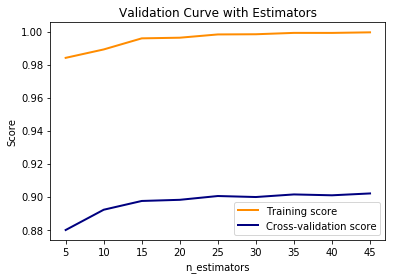

In [40]:
plt.title("Validation Curve with Estimators")
plt.xlabel("n_estimators")
plt.ylabel("Score")
lw=2
plt.plot(bc_param_range, bc_train_scores_mean, label="Training score",
             color="darkorange", lw=lw)
plt.plot(bc_param_range, bc_valid_scores_mean, label="Cross-validation score",
             color="navy", lw=lw)
plt.legend(loc="best")
plt.show()
plt.show()

In [47]:
bc = BaggingClassifier(n_estimators=200, n_jobs=-1, verbose=2)
bc.fit(X_train, Y_train)

/home/carnd/anaconda3/envs/dl/lib/python3.5/site-packages/sklearn/utils/validation.py:526: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Building estimator 1 of 6 for this parallel run (total 200)...
Building estimator 1 of 6 for this parallel run (total 200)...
Building estimator 1 of 6 for this parallel run (total 200)...
Building estimator 1 of 6 for this parallel run (total 200)...
Building estimator 1 of 6 for this parallel run (total 200)...
Building estimator 1 of 6 for this parallel run (total 200)...
Building estimator 1 of 6 for this parallel run (total 200)...
Building estimator 1 of 6 for this parallel run (total 200)...
Building estimator 1 of 6 for this parallel run (total 200)...
Building estimator 1 of 6 for this parallel run (total 200)...
Building estimator 1 of 6 for this parallel run (total 200)...
Building estimator 1 of 6 for this parallel run (total 200)...
Building estimator 1 of 6 for this parallel run (total 200)...
Building estimator 1 of 6 for this parallel run (total 200)...
Building estimator 1 of 6 for this parallel run (total 200)...
Building estimator 1 of 6 for this parallel run (total 

[Parallel(n_jobs=36)]: Done   3 out of  36 | elapsed:  1.3min remaining: 14.4min
[Parallel(n_jobs=36)]: Done  22 out of  36 | elapsed:  1.4min remaining:   54.5s
[Parallel(n_jobs=36)]: Done  36 out of  36 | elapsed:  1.5min finished


BaggingClassifier(base_estimator=None, bootstrap=True,
         bootstrap_features=False, max_features=1.0, max_samples=1.0,
         n_estimators=200, n_jobs=-1, oob_score=False, random_state=None,
         verbose=2, warm_start=False)

In [48]:
bc.score(X_test, Y_test)

[Parallel(n_jobs=36)]: Done   3 out of  36 | elapsed:    1.0s remaining:   11.2s
[Parallel(n_jobs=36)]: Done  22 out of  36 | elapsed:    3.7s remaining:    2.4s
[Parallel(n_jobs=36)]: Done  36 out of  36 | elapsed:    5.5s finished


0.90716491243886499

## Ensembled Model #6: ExtraTrees Classifier

In [49]:
from sklearn.ensemble import ExtraTreesClassifier

In [59]:
etc = ExtraTreesClassifier(n_estimators=200, n_jobs=-1, verbose=2)
etc.fit(X_train, Y_train)

/home/carnd/anaconda3/envs/dl/lib/python3.5/site-packages/ipykernel/__main__.py:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  from ipykernel import kernelapp as app


building tree 2 of 200building tree 3 of 200building tree 4 of 200building tree 5 of 200building tree 6 of 200building tree 7 of 200building tree 8 of 200building tree 9 of 200building tree 11 of 200building tree 12 of 200building tree 13 of 200building tree 15 of 200building tree 16 of 200building tree 18 of 200building tree 19 of 200building tree 20 of 200building tree 21 of 200building tree 22 of 200building tree 14 of 200building tree 23 of 200building tree 17 of 200building tree 1 of 200building tree 10 of 200building tree 26 of 200building tree 27 of 200building tree 28 of 200building tree 24 of 200building tree 29 of 200building tree 30 of 200building tree 25 of 200building tree 31 of 200building tree 32 of 200building tree 33 of 200building tree 34 of 200building tree 35 of 200

































building tree 36 of 200

building tree 37 of 200
building tree 38 of 200
building tree 39 of 200
building tree 40 of 200
building tree 41 of 200
building tree 42 of 200
b

[Parallel(n_jobs=-1)]: Done  90 tasks      | elapsed:    7.2s


building tree 126 of 200
building tree 127 of 200
building tree 129 of 200building tree 128 of 200

building tree 130 of 200
building tree 131 of 200
building tree 132 of 200
building tree 133 of 200
building tree 134 of 200
building tree 135 of 200
building tree 136 of 200
building tree 137 of 200
building tree 138 of 200
building tree 139 of 200
building tree 140 of 200
building tree 141 of 200
building tree 142 of 200
building tree 143 of 200
building tree 144 of 200
building tree 145 of 200
building tree 146 of 200
building tree 147 of 200
building tree 148 of 200
building tree 149 of 200
building tree 150 of 200
building tree 151 of 200
building tree 152 of 200
building tree 153 of 200
building tree 154 of 200building tree 155 of 200

building tree 156 of 200
building tree 157 of 200
building tree 158 of 200
building tree 159 of 200
building tree 160 of 200
building tree 161 of 200
building tree 162 of 200
building tree 163 of 200building tree 164 of 200

building tree 165 of 200


[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:   13.0s finished


ExtraTreesClassifier(bootstrap=False, class_weight=None, criterion='gini',
           max_depth=None, max_features='auto', max_leaf_nodes=None,
           min_impurity_split=1e-07, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=200, n_jobs=-1, oob_score=False, random_state=None,
           verbose=2, warm_start=False)

In [60]:
etc.score(X_test, Y_test)

[Parallel(n_jobs=36)]: Done  90 tasks      | elapsed:    0.8s
[Parallel(n_jobs=36)]: Done 200 out of 200 | elapsed:    1.4s finished


0.8421119850946982

## Ensembled Model #7: GradientBoostingClassifier

In [61]:
from sklearn.ensemble import GradientBoostingClassifier

In [65]:
gbc = GradientBoostingClassifier(n_estimators=1000, max_depth=3, verbose=2)
gbc.fit(X_train, Y_train)

/home/carnd/anaconda3/envs/dl/lib/python3.5/site-packages/sklearn/utils/validation.py:526: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


      Iter       Train Loss   Remaining Time 
         1           1.0483           10.84m
         2           1.0173           11.33m
         3           0.9938           11.15m
         4           0.9753           11.04m
         5           0.9603           10.97m
         6           0.9479           11.04m
         7           0.9375           11.10m
         8           0.9287           11.12m
         9           0.9212           11.14m
        10           0.9138           11.28m
        11           0.9082           11.27m
        12           0.9024           11.35m
        13           0.8963           11.44m
        14           0.8923           11.41m
        15           0.8882           11.47m
        16           0.8844           11.48m
        17           0.8813           11.51m
        18           0.8782           11.56m
        19           0.8756           11.56m
        20           0.8728           11.56m
        21           0.8701           11.53m
        2

GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_split=1e-07, min_samples_leaf=1,
              min_samples_split=2, min_weight_fraction_leaf=0.0,
              n_estimators=1000, presort='auto', random_state=None,
              subsample=1.0, verbose=2, warm_start=False)

In [66]:
gbc.score(X_test, Y_test)

0.90215390625586933

## Ensembled Model #8: PassiveAggressiveClassifier

In [67]:
from sklearn.linear_model import PassiveAggressiveClassifier

In [74]:
pac = PassiveAggressiveClassifier(n_iter=5, verbose=2, n_jobs=-1)
pac.fit(X_train, Y_train)

/home/carnd/anaconda3/envs/dl/lib/python3.5/site-packages/sklearn/utils/validation.py:526: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


-- Epoch 1
Norm: 0.00, NNZs: 41, Bias: -0.000001, T: 399321, Avg. loss: 1.138124
Total training time: 0.10 seconds.
-- Epoch 2
Norm: 0.00, NNZs: 41, Bias: -0.000002, T: 798642, Avg. loss: 1.126260
Total training time: 0.20 seconds.
-- Epoch 3
Norm: 0.00, NNZs: 41, Bias: -0.000003, T: 1197963, Avg. loss: 1.120333
Total training time: 0.30 seconds.
-- Epoch 4
Norm: 0.00, NNZs: 41, Bias: -0.000004, T: 1597284, Avg. loss: 1.114581
Total training time: 0.40 seconds.
-- Epoch 5
Norm: 0.00, NNZs: 41, Bias: -0.000006, T: 1996605, Avg. loss: 1.109557
Total training time: 0.50 seconds.


PassiveAggressiveClassifier(C=1.0, class_weight=None, fit_intercept=True,
              loss='hinge', n_iter=5, n_jobs=-1, random_state=None,
              shuffle=True, verbose=2, warm_start=False)

In [75]:
pac.score(X_test, Y_test)

0.81366118986980396

## Ensembled Model #9: RidgeClassifier

In [76]:
from sklearn.linear_model import RidgeClassifier

In [77]:
rc = RidgeClassifier()
rc.fit(X_train, Y_train)

/home/carnd/anaconda3/envs/dl/lib/python3.5/site-packages/sklearn/linear_model/ridge.py:780: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


RidgeClassifier(alpha=1.0, class_weight=None, copy_X=True, fit_intercept=True,
        max_iter=None, normalize=False, random_state=None, solver='auto',
        tol=0.001)

In [78]:
rc.score(X_test, Y_test)

0.79612642460576832

## Emsemble Model with LR

In [84]:
pred_train_rf = rf.predict(X_train)
pred_train_knc = knc.predict(X_train)
pred_train_sgd = sgd.predict(X_train)
pred_train_abc = abc.predict(X_train)
pred_train_bc = bc.predict(X_train)
pred_train_etc = etc.predict(X_train)
pred_train_gbc = gbc.predict(X_train)
pred_train_pac = pac.predict(X_train)
pred_train_rc = rc.predict(X_train)

[Parallel(n_jobs=36)]: Done  50 out of 100 | elapsed:    0.8s remaining:    0.8s
[Parallel(n_jobs=36)]: Done  71 out of 100 | elapsed:    0.9s remaining:    0.4s
[Parallel(n_jobs=36)]: Done  92 out of 100 | elapsed:    1.1s remaining:    0.1s
[Parallel(n_jobs=36)]: Done 100 out of 100 | elapsed:    1.2s finished
[Parallel(n_jobs=36)]: Done   3 out of  36 | elapsed:    2.4s remaining:   26.4s
[Parallel(n_jobs=36)]: Done  22 out of  36 | elapsed:    7.2s remaining:    4.6s
[Parallel(n_jobs=36)]: Done  36 out of  36 | elapsed:   10.6s finished
[Parallel(n_jobs=36)]: Done  90 tasks      | elapsed:    1.5s
[Parallel(n_jobs=36)]: Done 200 out of 200 | elapsed:    2.8s finished


In [85]:
prediction_train = pd.DataFrame({
    'rf': pred_train_rf,
    'knc': pred_train_knc,
    'sgd': pred_train_sgd,
    'abc': pred_train_abc,
    'bc': pred_train_bc,
    'etc': pred_train_etc,
    'gbc': pred_train_gbc,
    'pac': pred_train_pac,
    'rc': pred_train_rc,
})

In [90]:
from sklearn.linear_model import LogisticRegression

#ensemble = RandomForestClassifier(n_estimators=100, verbose=5, n_jobs=-1)
ensemble = LogisticRegression(solver='sag', verbose=2, n_jobs=-1)
ensemble.fit(prediction_train, Y_train)

/home/carnd/anaconda3/envs/dl/lib/python3.5/site-packages/sklearn/utils/validation.py:526: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


convergence after 19 epochs took 2 seconds


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    2.2s finished


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=-1,
          penalty='l2', random_state=None, solver='sag', tol=0.0001,
          verbose=2, warm_start=False)

In [87]:
pred_test_rf = rf.predict(X_test)
pred_test_knc = knc.predict(X_test)
pred_test_sgd = sgd.predict(X_test)
pred_test_abc = abc.predict(X_test)
pred_test_bc = bc.predict(X_test)
pred_test_etc = etc.predict(X_test)
pred_test_gbc = gbc.predict(X_test)
pred_test_pac = pac.predict(X_test)
pred_test_rc = rc.predict(X_test)

[Parallel(n_jobs=36)]: Done  50 out of 100 | elapsed:    0.3s remaining:    0.3s
[Parallel(n_jobs=36)]: Done  71 out of 100 | elapsed:    0.4s remaining:    0.2s
[Parallel(n_jobs=36)]: Done  92 out of 100 | elapsed:    0.4s remaining:    0.0s
[Parallel(n_jobs=36)]: Done 100 out of 100 | elapsed:    0.5s finished
[Parallel(n_jobs=36)]: Done   3 out of  36 | elapsed:    1.0s remaining:   11.3s
[Parallel(n_jobs=36)]: Done  22 out of  36 | elapsed:    3.5s remaining:    2.3s
[Parallel(n_jobs=36)]: Done  36 out of  36 | elapsed:    5.5s finished
[Parallel(n_jobs=36)]: Done  90 tasks      | elapsed:    0.5s
[Parallel(n_jobs=36)]: Done 200 out of 200 | elapsed:    1.0s finished


In [88]:
prediction_test = pd.DataFrame({
    'rf': pred_test_rf,
    'knc': pred_test_knc,
    'sgd': pred_test_sgd,
    'abc': pred_test_abc,
    'bc': pred_test_bc,
    'etc': pred_test_etc,
    'gbc': pred_test_gbc,
    'pac': pred_test_pac,
    'rc': pred_test_rc,
})

In [96]:
ensemble.score(prediction_test, Y_test)

0.86176534667598248

In [ ]:
fi = list(zip(prediction_test.columns.values, ensemble.feature_importances_))
fi = sorted(fi, key=lambda x: -x[1])
pd.DataFrame(fi, columns=["Feature","Importance"])

In [95]:
prediction_train.to_csv('ensemble_train.csv', index=False)
prediction_test.to_csv('ensemble_test.csv', index=False)

**Observation**:  In RandomForest Ensemble, performance is occupied by the best model. Does not increase.

## Ensemble Model with Voting Classifier

In [20]:
from sklearn.ensemble import VotingClassifier

In [81]:
ensemble_vote = VotingClassifier(estimators=[
    ('rf', rf),
    ('knc', knc),
    ('sgd', sgd),
    ('abc', abc),
    ('bc', bc),
    ('etc', etc),
    ('gbc', gbc),
    ('pac', pac),
    ('rc', rc)
], voting='soft', n_jobs=-1)

In [83]:
ensemble_vote.fit(X_train, Y_train)

/home/carnd/anaconda3/envs/dl/lib/python3.5/site-packages/sklearn/preprocessing/label.py:108: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/carnd/anaconda3/envs/dl/lib/python3.5/site-packages/sklearn/preprocessing/label.py:143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


building tree 3 of 100
building tree 14 of 100
building tree 6 of 100
building tree 19 of 100
building tree 11 of 100
building tree 25 of 100
building tree 20 of 100
building tree 16 of 100
building tree 31 of 100
building tree 21 of 100
building tree 7 of 100
building tree 15 of 100
building tree 22 of 100
building tree 17 of 100
building tree 4 of 100
building tree 18 of 100
building tree 12 of 100
building tree 27 of 100
building tree 34 of 100
building tree 23 of 100
building tree 5 of 100
building tree 32 of 100
building tree 26 of 100
building tree 36 of 100
building tree 10 of 100
building tree 29 of 100
building tree 1 of 100
building tree 28 of 100
building tree 24 of 100
building tree 9 of 100
building tree 30 of 100
building tree 13 of 100
building tree 2 of 100
building tree 8 of 100
building tree 35 of 100
building tree 33 of 100
-- Epoch 1


/home/carnd/anaconda3/envs/dl/lib/python3.5/site-packages/sklearn/externals/joblib/parallel.py:540: UserWarning: Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1
  **self._backend_args)


Norm: 324954.96, NNZs: 41, Bias: 2406.741789, T: 798642, Avg. loss: 10692641343.489632
Norm: 419793.33, NNZs: 41, Bias: 2252.797814, T: 399321, Avg. loss: 19000028890.553448
Building estimator 1 of 6 for this parallel run (total 200)...
Total training time: 0.25 seconds.
-- Epoch 2
Total training time: 0.57 seconds.
-- Epoch 3
building tree 37 of 100
Norm: 278557.05, NNZs: 41, Bias: 2465.833951, T: 1197963, Avg. loss: 7595170118.520350
Total training time: 0.87 seconds.
-- Epoch 4
building tree 38 of 100
Norm: 251000.74, NNZs: 41, Bias: 2505.691041, T: 1597284, Avg. loss: 5947894317.413574
Total training time: 1.16 seconds.
-- Epoch 5
building tree 39 of 100
Norm: 232633.09, NNZs: 41, Bias: 2540.212348, T: 1996605, Avg. loss: 4913409689.636926
Total training time: 1.38 seconds.
-- Epoch 6
building tree 40 of 100
building tree 41 of 100
Norm: 219106.15, NNZs: 41, Bias: 2564.729045, T: 2395926, Avg. loss: 4199689236.775273
Total training time: 1.58 seconds.
-- Epoch 7
building tree 43 of

[Parallel(n_jobs=-1)]: Done  50 out of 100 | elapsed:   12.0s remaining:   12.0s


building tree 86 of 100
building tree 87 of 100
Norm: 127171.56, NNZs: 41, Bias: 2647.978866, T: 11180988, Avg. loss: 1088695714.101491
building tree 88 of 100
Total training time: 9.47 seconds.
-- Epoch 29
building tree 89 of 100
building tree 90 of 100
building tree 91 of 100
Norm: 125482.78, NNZs: 41, Bias: 2647.258658, T: 11580309, Avg. loss: 1055278196.438360
building tree 92 of 100
Total training time: 9.90 seconds.
-- Epoch 30
building tree 93 of 100
building tree 94 of 100
building tree 95 of 100
Norm: 123816.59, NNZs: 41, Bias: 2646.964587, T: 11979630, Avg. loss: 1023988800.163254
Total training time: 10.34 seconds.
building tree 96 of 100
-- Epoch 31
building tree 97 of 100
building tree 98 of 100
building tree 99 of 100
building tree 73 of 200
Norm: 122662.15, NNZs: 41, Bias: 2645.833783, T: 12378951, Avg. loss: 994635320.490451
Total training time: 10.75 seconds.
-- Epoch 32
building tree 74 of 200
building tree 76 of 200
building tree 75 of 200
building tree 77 of 200
bui

[Parallel(n_jobs=-1)]: Done  71 out of 100 | elapsed:   14.4s remaining:    5.9s


building tree 84 of 200
Norm: 118011.69, NNZs: 41, Bias: 2643.825400, T: 13576914, Avg. loss: 916043736.924312
Total training time: 11.98 seconds.
-- Epoch 35
building tree 85 of 200
building tree 86 of 200
building tree 87 of 200
building tree 88 of 200
building tree 89 of 200
building tree 91 of 200
building tree 90 of 200
Norm: 116813.86, NNZs: 41, Bias: 2643.265037, T: 13976235, Avg. loss: 892719157.793785
building tree 92 of 200
Total training time: 12.43 seconds.
-- Epoch 36
building tree 94 of 200
         2           1.0173           77.41m
building tree 93 of 200
building tree 95 of 200
Norm: 115445.81, NNZs: 41, Bias: 2641.932374, T: 14375556, Avg. loss: 870544458.983413
Total training time: 12.88 seconds.
-- Epoch 37
building tree 96 of 200
building tree 97 of 200
building tree 98 of 200
Norm: 114066.23, NNZs: 41, Bias: 2640.692621, T: 14774877, Avg. loss: 849487664.145281
Total training time: 13.30 seconds.
-- Epoch 38
building tree 99 of 200
building tree 100 of 200
buildi

[Parallel(n_jobs=-1)]: Done  92 out of 100 | elapsed:   18.0s remaining:    1.6s


building tree 119 of 200
building tree 120 of 200
Norm: 107464.54, NNZs: 41, Bias: 2634.842177, T: 17170803, Avg. loss: 742864282.080491
Total training time: 15.56 seconds.
-- Epoch 44
building tree 121 of 200
building tree 122 of 200
building tree 123 of 200
building tree 124 of 200
building tree 125 of 200
Norm: 106446.90, NNZs: 41, Bias: 2633.699775, T: 17570124, Avg. loss: 727740886.769196
Total training time: 15.81 seconds.
-- Epoch 45
building tree 127 of 200


[Parallel(n_jobs=-1)]: Done  90 tasks      | elapsed:   14.4s


building tree 126 of 200
Norm: 105420.79, NNZs: 41, Bias: 2632.439303, T: 17969445, Avg. loss: 713192733.114041
Total training time: 16.02 seconds.
-- Epoch 46
building tree 128 of 200
building tree 129 of 200


[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   18.7s finished


Norm: 104405.64, NNZs: 41, Bias: 2631.528240, T: 18368766, Avg. loss: 699321061.227770
Total training time: 16.21 seconds.
         3           0.9938           71.47m
-- Epoch 47
building tree 130 of 200
building tree 131 of 200
building tree 132 of 200
Norm: 103445.97, NNZs: 41, Bias: 2630.536900, T: 18768087, Avg. loss: 686004288.466488
Total training time: 16.46 seconds.
-- Epoch 48
building tree 133 of 200
Norm: 102537.25, NNZs: 41, Bias: 2629.526612, T: 19167408, Avg. loss: 673197326.060853
Total training time: 16.64 seconds.
-- Epoch 49
building tree 134 of 200
building tree 135 of 200
building tree 136 of 200
Norm: 101638.55, NNZs: 41, Bias: 2628.975290, T: 19566729, Avg. loss: 660895915.426543
Total training time: 16.83 seconds.
-- Epoch 50
building tree 137 of 200
building tree 138 of 200
Norm: 100727.29, NNZs: 41, Bias: 2628.054074, T: 19966050, Avg. loss: 649070890.884876
Total training time: 17.01 seconds.
-- Epoch 51
building tree 139 of 200
building tree 140 of 200
build

[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:   21.3s finished


Norm: 82121.55, NNZs: 41, Bias: 2606.921502, T: 31546359, Avg. loss: 430543612.739707
Total training time: 22.90 seconds.
-- Epoch 80
         6           0.9479           54.06m
Norm: 81665.03, NNZs: 41, Bias: 2606.752689, T: 31945680, Avg. loss: 425709911.631912
Total training time: 23.02 seconds.
-- Epoch 81
Norm: 81199.65, NNZs: 41, Bias: 2606.318157, T: 32345001, Avg. loss: 420993145.335640
Total training time: 23.12 seconds.
-- Epoch 82
Norm: 80734.40, NNZs: 41, Bias: 2605.505222, T: 32744322, Avg. loss: 416376764.518218
Total training time: 23.27 seconds.
-- Epoch 83
Norm: 80274.37, NNZs: 41, Bias: 2604.854167, T: 33143643, Avg. loss: 411856065.177952
Total training time: 23.37 seconds.
-- Epoch 84
Norm: 79848.18, NNZs: 41, Bias: 2604.599549, T: 33542964, Avg. loss: 407451860.947677
Total training time: 23.48 seconds.
-- Epoch 85
Norm: 79420.63, NNZs: 41, Bias: 2604.160625, T: 33942285, Avg. loss: 403130252.141788
Total training time: 23.58 seconds.
-- Epoch 86
Norm: 78990.04, N

[Parallel(n_jobs=36)]: Done   1 out of   1 | elapsed:  1.0min remaining:    0.0s


Building estimator 1 of 6 for this parallel run (total 200)...
Norm: 34546.66, NNZs: 41, Bias: 2612.246486, T: 162523647, Avg. loss: 97266751.210106
Total training time: 61.15 seconds.
-- Epoch 408
Norm: 34499.16, NNZs: 41, Bias: 2612.365277, T: 162922968, Avg. loss: 97048184.558636
Total training time: 61.28 seconds.
-- Epoch 409
Norm: 34454.02, NNZs: 41, Bias: 2612.380476, T: 163322289, Avg. loss: 96831117.531498
Total training time: 61.41 seconds.
-- Epoch 410
Norm: 34406.62, NNZs: 41, Bias: 2612.495935, T: 163721610, Avg. loss: 96615053.810508
Total training time: 61.52 seconds.
-- Epoch 411
Norm: 34363.67, NNZs: 41, Bias: 2612.595764, T: 164120931, Avg. loss: 96400129.319902
Total training time: 61.63 seconds.
-- Epoch 412
        54           0.8138           17.04m
Norm: 34320.98, NNZs: 41, Bias: 2612.675562, T: 164520252, Avg. loss: 96186243.604745
Total training time: 61.76 seconds.
-- Epoch 413
Norm: 34277.83, NNZs: 41, Bias: 2612.699266, T: 164919573, Avg. loss: 95973367.364

[Parallel(n_jobs=36)]: Done  36 out of  36 | elapsed: 24.7min finished


MaybeEncodingError: Error sending result: '[ExtraTreesClassifier(bootstrap=False, class_weight=None, criterion='gini',
           max_depth=None, max_features='auto', max_leaf_nodes=None,
           min_impurity_split=1e-07, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=200, n_jobs=-1, oob_score=False, random_state=None,
           verbose=2, warm_start=False)]'. Reason: 'error("'i' format requires -2147483648 <= number <= 2147483647",)'

In [ ]:
ensemble_vote.score(X_test, Y_test)

## Prediction

In [98]:
data_test = pd.read_csv("input/test_indessa.csv")
rows = data_test['member_id'].copy()

In [99]:
data_test = data_test.fillna("0")

In [100]:
data_test['last_week_pay'] = data_test['last_week_pay'].str.extract('(\d+)', expand=False)
data_test = data_test.fillna("0")
data_test['last_week_pay'] = data_test['last_week_pay'].astype(int)

In [101]:
data_test['term'] = data_test['term'].str.extract('(\d+)', expand=False).astype(int)
data_test = data_test.fillna("0")
data_test['term'] = data_test['term'].astype(int)

In [102]:
# Extract a new feature from term and last week pay

data_test.insert(0, 'payment_completion', (data_test['last_week_pay']/(data_test['term']/12*52+1))*100)
data_test['payment_completion'] = data_test['payment_completion'].astype(int)

In [103]:
# Extract a new feature from funded_amnt_inv / loan_amnt

data_test.insert(0, 'funded_ratio', (data_test['funded_amnt_inv']/data_test['loan_amnt'])*100)
data_test['funded_ratio'] = data_test['funded_ratio'].astype(int)

In [104]:
# Drop irrelevant features and text features
drop_cols = ['member_id', 'batch_enrolled', 'desc', 'title', 'emp_title']
data_test.drop(drop_cols, 1, inplace=True)

In [105]:
# Encode Label for Classifier
from sklearn.preprocessing import LabelEncoder

cat_cols = ['grade', 'sub_grade', 'emp_length', 'home_ownership', 'verification_status', 
            'pymnt_plan', 'purpose', 'initial_list_status', 'application_type', 
            'verification_status_joint', 'zip_code', 'addr_state']
le = {}

for col in cat_cols:
    le[col] = LabelEncoder()
    data_test[col] = le[col].fit_transform(data_test[col])
    le[col].classes_ = np.append(le[col].classes_, 'other')
    
    print('Encoded: ', col)

Encoded:  grade
Encoded:  sub_grade
Encoded:  emp_length
Encoded:  home_ownership
Encoded:  verification_status
Encoded:  pymnt_plan
Encoded:  purpose
Encoded:  initial_list_status
Encoded:  application_type
Encoded:  verification_status_joint
Encoded:  zip_code
Encoded:  addr_state


In [108]:
# Bagging Classifier
save_pred_bc = bc.predict_proba(data_test)

[Parallel(n_jobs=36)]: Done   3 out of  36 | elapsed:    2.3s remaining:   25.2s
[Parallel(n_jobs=36)]: Done  22 out of  36 | elapsed:    6.9s remaining:    4.4s
[Parallel(n_jobs=36)]: Done  36 out of  36 | elapsed:   10.0s finished


In [110]:
save_pred_bc_frame = pd.DataFrame({'member_id': rows, 'loan_status': save_pred_bc[:,1]})
save_pred_bc_frame.to_csv('submission_bagging.csv', index=False, columns=['member_id', 'loan_status'], float_format='%g')

In [112]:
# GradientBoostClassifier
save_pred_gbc = gbc.predict_proba(data_test)

In [114]:
save_pred_gbc_frame = pd.DataFrame({'member_id': rows, 'loan_status': save_pred_gbc[:,1]})
save_pred_gbc_frame = save_pred_gbc_frame.round(2)
save_pred_gbc_frame.to_csv('submission_gbc.csv', index=False, columns=['member_id', 'loan_status'], float_format='%g')

In [116]:
# Ensemble Classifier
save_pred_test_rf = rf.predict(data_test)
save_pred_test_knc = knc.predict(data_test)
save_pred_test_sgd = sgd.predict(data_test)
save_pred_test_abc = abc.predict(data_test)
save_pred_test_bc = bc.predict(data_test)
save_pred_test_etc = etc.predict(data_test)
save_pred_test_gbc = gbc.predict(data_test)
save_pred_test_pac = pac.predict(data_test)
save_pred_test_rc = rc.predict(data_test)

[Parallel(n_jobs=36)]: Done  50 out of 100 | elapsed:    0.6s remaining:    0.6s
[Parallel(n_jobs=36)]: Done  71 out of 100 | elapsed:    0.8s remaining:    0.3s
[Parallel(n_jobs=36)]: Done  92 out of 100 | elapsed:    0.9s remaining:    0.1s
[Parallel(n_jobs=36)]: Done 100 out of 100 | elapsed:    0.9s finished
[Parallel(n_jobs=36)]: Done   3 out of  36 | elapsed:    2.2s remaining:   24.3s
[Parallel(n_jobs=36)]: Done  22 out of  36 | elapsed:    7.0s remaining:    4.4s
[Parallel(n_jobs=36)]: Done  36 out of  36 | elapsed:   10.5s finished
[Parallel(n_jobs=36)]: Done  90 tasks      | elapsed:    1.3s
[Parallel(n_jobs=36)]: Done 200 out of 200 | elapsed:    2.4s finished


In [120]:
save_prediction_test = pd.DataFrame({
    'rf': save_pred_test_rf,
    'knc': save_pred_test_knc,
    'sgd': save_pred_test_sgd,
    'abc': save_pred_test_abc,
    'bc': save_pred_test_bc,
    'etc': save_pred_test_etc,
    'gbc': save_pred_test_gbc,
    'pac': save_pred_test_pac,
    'rc': save_pred_test_rc,
})

In [121]:
save_pred_en = ensemble.predict_proba(save_prediction_test)

In [122]:
save_pred_en_frame = pd.DataFrame({'member_id': rows, 'loan_status': save_pred_en[:,1]})
save_pred_en_frame = save_pred_en_frame.round(2)
save_pred_en_frame.to_csv('submission_en.csv', index=False, columns=['member_id', 'loan_status'], float_format='%g')